In [36]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import faiss
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

data = pd.read_csv('data/apache/data.csv')

print("Sütun Adları:", data.columns)

data['Date'] = pd.to_datetime(data['Date'].str.strip('[]'), format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')

missing_values = data.isnull().sum()
print("Eksik Veriler:", missing_values)

data = data.drop(columns=['Referrer', 'User Agent'], errors='ignore')

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Hour'] = data['Date'].dt.hour
data['Minute'] = data['Date'].dt.minute

data['Status Code'] = pd.to_numeric(data['Status Code'], errors='coerce')

data = data.dropna(subset=['Request', 'Endpoint', 'Status Code'])
data = data[data['Request'].str.strip() != '']
data = data[data['Endpoint'].str.strip() != '']
data = data[data['Status Code'].notna()] 

data['Combined'] = data['Request'] + ' ' + data['Endpoint'] + ' ' + data['Status Code'].astype(str)

print(data['Combined'].head())
print(data['Combined'].isnull().sum())

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Combined']).toarray()

index = faiss.IndexFlatL2(X.shape[1])
index.add(X.astype('float32'))

def find_relevant_logs(query):
    query_vector = vectorizer.transform([query]).toarray().astype('float32')
    D, I = index.search(query_vector, 5)
    return data.iloc[I[0]]

def generate_response(logs):
    input_text = " ".join(
        logs.apply(lambda row: f"{row['Date']} {row['Request']} {row['Endpoint']} {row['Status Code']}",
                   axis=1).tolist())
    input_text = input_text[:1000]  # Giriş metnini 1000 karakterle sınırlama

    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    output = model.generate(input_ids, attention_mask=attention_mask, max_length=150, num_return_sequences=1,
                            pad_token_id=tokenizer.eos_token_id)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

def answer_question(query):
    relevant_logs = find_relevant_logs(query)
    response = generate_response(relevant_logs)
    return response

model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

Sütun Adları: Index(['IP Address', 'Date', 'Request', 'Endpoint', 'Status Code',
       'Response Size', 'Referrer', 'User Agent', 'Time Taken'],
      dtype='object')
Eksik Veriler: IP Address       0
Date             0
Request          0
Endpoint         0
Status Code      0
Response Size    0
Referrer         0
User Agent       0
Time Taken       0
dtype: int64
0                 GET /usr/admin 502
1                POST /usr/login 500
2    DELETE /usr/admin/developer 200
3       PUT /usr/admin/developer 200
4           DELETE /usr/register 502
Name: Combined, dtype: object
0


C:\Users\reyiz\anaconda3\envs\NLP\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [37]:
# Test Sorguları Listesi
queries = [
    "Son 24 saatte hangi URL'ler 500 hatası aldı?",
    "Son bir ayda hangi IP adresleri en fazla 403 hatası aldı?",
    "Son bir yıl içinde en sık kullanılan POST isteklerinin listesi nedir?",
    "Son 30 gün içinde hangi tarayıcılar en fazla 404 hatası aldı?",
    "Son haftada hangi endpoint'ler en yüksek Response Size'a sahipti?",
    "En son 10 istekte hangi User Agent'lar kullanıldı?",
    "En yüksek zaman alımı (Time Taken) olan 5 istek nedir?",
    "Son 6 ayda hangi Referrer en çok ziyaret edildi?",
    "Son 24 saatte hangi Endpoint'lerde 502 hatası alındı?",
    "Hangi IP adresleri en uzun süre GET isteği yaptı?",
    "Which IP adress has Longest GET time ?",
]

In [38]:
# Her bir sorguyu test etme
for query in queries:
    print("-" * 80)
    print("\n")
    
    response = answer_question(query)
    print(f"Sorgu: {query}")
    print(f"Modelin Yanıtı: {response}")
    print("\n")


--------------------------------------------------------------------------------


Sorgu: Son 24 saatte hangi URL'ler 500 hatası aldı?
Modelin Yanıtı: 2018-12-27 04:34:16+03:00 DELETE /usr 500 2019-05-14 12:22:36+03:00 DELETE /usr 500 2019-10-26 04:08:14+03:00 DELETE /usr 500 2018-02-22 02:17:07+03:00 DELETE /usr 500 2019-05-15 11:50:22+03:00 DELETE /usr 500 2018-02-22 02:17:07+03:00 DELETE /usr 500 2018-02-22 02:17:07+03:00 DELETE /usr 500 2018-02-22 02:17:07


--------------------------------------------------------------------------------


Sorgu: Son bir ayda hangi IP adresleri en fazla 403 hatası aldı?
Modelin Yanıtı: 2018-09-22 11:54:40+03:00 DELETE /usr 403 2019-10-20 03:23:24+03:00 DELETE /usr 403 2018-07-02 01:28:17+03:00 DELETE /usr 403 2019-11-09 10:22:37+03:00 DELETE /usr 403 2019-11-19 04:24:37+03:00 DELETE /usr 403 2019-11-18 04:24:37+03:00 DELETE /usr 403 2019-11-17 04:24:37+03:00 DELETE /usr 403 2019-11-16 04:24:37


-----------------------------------------------------

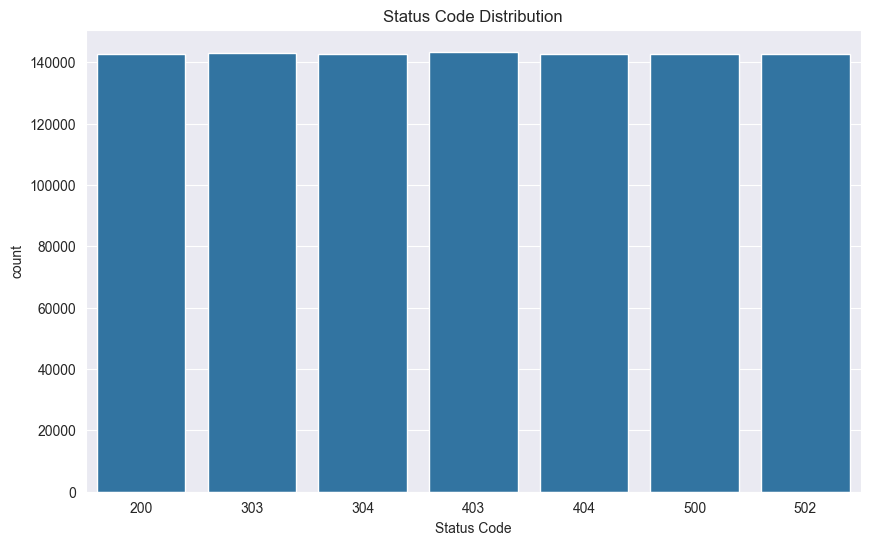

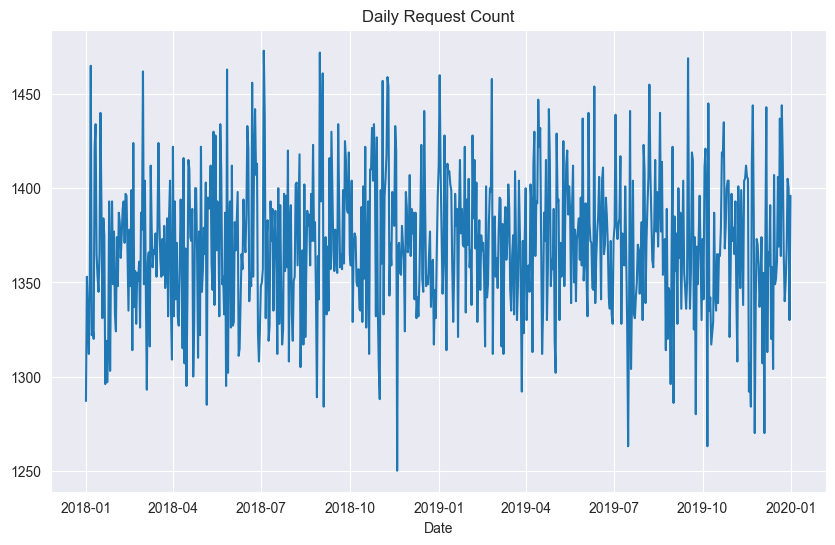

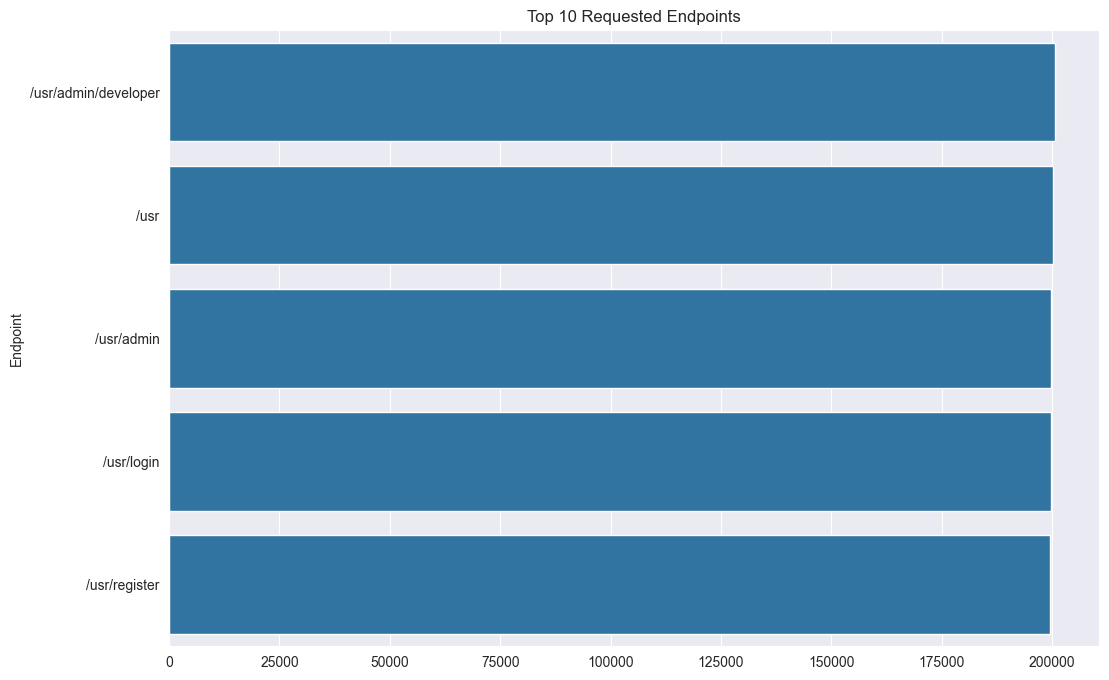

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hata kodlarının dağılımı
plt.figure(figsize=(10, 6))
sns.countplot(x='Status Code', data=data)
plt.title('Status Code Distribution')
plt.show()

# Günlük istek sayısı
daily_requests = data['Date'].dt.date.value_counts().sort_index()
plt.figure(figsize=(10, 6))
daily_requests.plot(kind='line')
plt.title('Daily Request Count')
plt.show()

# Endpoint'lere göre en sık yapılan istekler
plt.figure(figsize=(12, 8))
top_endpoints = data['Endpoint'].value_counts().nlargest(10)
sns.barplot(x=top_endpoints.values, y=top_endpoints.index)
plt.title('Top 10 Requested Endpoints')
plt.show()
